# Baseline Model for Age Prediction

With ROI-based measures of FA/MD as input features and simple MLP as our model, how good can we achieve?

Author: Chenyu Gao

Date: Jul 17, 2023

In [1]:
import warnings
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from functions import *
from tqdm import tqdm
from sklearn.model_selection import KFold

random_seed = 42
warnings.filterwarnings('ignore')

In [2]:
class MLP(nn.Module):
    def __init__(self, input_size = 537, output_size = 1, hidden_layer_sizes = [128, 64]):
        super(MLP, self).__init__()
        layers = []
        for size in hidden_layer_sizes:
            layers.append(nn.Linear(input_size, size))
            layers.append(nn.ReLU())
            input_size = size

        layers.append(nn.Linear(input_size, output_size))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

### Select out the "best" MLP hyperparameters

In [ ]:
# load training set
df = pd.read_csv('./data/ROIbased_measure_train.csv')
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

unique_subjects = df['Subject'].unique()
subject_indices = np.arange(len(unique_subjects))  # used for fold-splitting in cross-validation

# convert categorical value to one-hot encoding
df_encoded = pd.get_dummies(df, columns=['Sex'], drop_first=True)
X = df_encoded.drop(['Dataset', 'Subject', 'Session', 'Sample', 'Diagnosis', 'Age'], axis=1)  # n rows × 537 columns
y = df_encoded['Age']  # n x 1

X = torch.Tensor(X.values)
y = torch.Tensor(y.values.reshape(-1,1))

# List of hyperparams for MLPs to try
list_hidden_layer_sizes = [[32], [64], [128],
                           [32, 8], [64, 32], [128, 64],
                           [32, 16, 8], [64, 32, 8],
                           [128, 32, 8], [128, 64, 8]]

# Cross validation for each MLP
list_mae_train_all_model = []
list_mae_vali_all_model = []
list_number_params_all_model = []

for hidden_layer_sizes in tqdm(list_hidden_layer_sizes):

    kf = KFold(n_splits=5, shuffle=True, random_state=random_seed)
    
    list_mae_train_current_model = []
    list_mae_vali_current_model = []  # MAE in each fold
    
    # 5 fold cross validation on subject level
    for sub_indices_train, sub_indices_val in kf.split(subject_indices):
        
        torch.manual_seed(random_seed)
        model = MLP(hidden_layer_sizes=hidden_layer_sizes)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        batch_size = 64
        num_epochs = 300
        
        train_index = df[df['Subject'].isin(unique_subjects[sub_indices_train])].index.values
        val_index = df[df['Subject'].isin(unique_subjects[sub_indices_val])].index.values
        
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # DataLoader for mini-batch training
        train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        # Train the model
        list_mae_train = []
        list_mae_val = []
        for epoch in range(num_epochs):
            model.train()

            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            # Evaluate the model on testing and validation
            model.eval()
            with torch.no_grad():
                outputs_train = model(X_train)
                outputs_val = model(X_val)
            
            list_mae_train.append(torch.mean(torch.abs(outputs_train - y_train).float()).item())        
            list_mae_val.append(torch.mean(torch.abs(outputs_val - y_val).float()).item())
            
        list_mae_train_current_model.append(list_mae_train)
        list_mae_vali_current_model.append(list_mae_val)
        
    list_mae_train_all_model.append(list_mae_train_current_model)
    list_mae_vali_all_model.append(list_mae_vali_current_model)
    list_number_params_all_model.append(sum(torch.numel(param) for param in model.parameters()))

In [ ]:
# Visualize MAE on validation
import matplotlib.pyplot as plt
import matplotlib.cm as cm

colors = cm.get_cmap('tab10', 10)

num_model = len(list_mae_vali_all_model)
for i in range(num_model):
    
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize = (40, 5))
    
    for j in range(len(list_mae_vali_all_model[i])):
        axes[j].plot([k+1 for k in range(num_epochs)],
                     list_mae_vali_all_model[i][j], 
                     linestyle='--',
                     color=colors(j),
                     label='validation')   
        axes[j].plot([k+1 for k in range(num_epochs)],
                     list_mae_train_all_model[i][j],
                     linestyle='-',
                     color=colors(j),
                     label='train')   
        axes[j].legend()
        axes[j].set_xlabel('Epoch')
        axes[j].set_ylabel('MAE')
        axes[j].set_title('fold-{}'.format(j+1))
        axes[j].set_ylim(bottom=3, top=10)
    
    fig.suptitle('MLP (hidden_layer_sizes = {}) Total #parameters: {}'.format(list_hidden_layer_sizes[i], 
                                                                              list_number_params_all_model[i]))
    name_model = '-'+ ''.join(str(x) + '-' for x in list_hidden_layer_sizes[i])
    fig.savefig('./figs/MLP{}five_fold_cross_validation.png'.format(name_model), bbox_inches='tight')
plt.close('all')

### Train the selected MLP on the entire training set

In [ ]:
# load training set
df = pd.read_csv('./data/ROIbased_measure_train.csv')
df.dropna(inplace=True)
df_encoded = pd.get_dummies(df, columns=['Sex'], drop_first=True)
X = df_encoded.drop(['Dataset', 'Subject', 'Session', 'Sample', 'Diagnosis', 'Age'], axis=1)
y = df_encoded['Age']
X = torch.Tensor(X.values)
y = torch.Tensor(y.values.reshape(-1,1))

# Define model and hyperparams
torch.manual_seed(random_seed)
model = MLP(hidden_layer_sizes=[64, 32, 8])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
batch_size = 64
num_epochs = 100  # TODO
epoch_check_points = [60, 70, 80, 90, 100]

# DataLoader
train_dataset = torch.utils.data.TensorDataset(X, y)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Train the model
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
    # evaluate and save model at check points
    if (epoch+1) in epoch_check_points:
        model.eval()
        with torch.no_grad():
            outputs = model(X)
            mae = torch.mean(torch.abs(outputs - y).float()).item()
            print("epoch {}\tMAE={}".format(epoch+1, mae))
        # Save the model
        torch.save(model.state_dict(), './model/MLP_model_epoch-{}.pth'.format(epoch+1))

In [3]:
# Load the saved model
model = MLP(hidden_layer_sizes=[64, 32, 8])
model.load_state_dict(torch.load('./model/MLP_model_epoch-80.pth'))

<All keys matched successfully>

### Test the performance on unseen testing data

#### Cohort 1: Healthy subjects

In [4]:
# Load data
df_test_healthy = pd.read_csv('./data/ROIbased_measure_test_healthy.csv')
df_test_healthy.dropna(inplace=True)
df_test_healthy_encoded = pd.get_dummies(df_test_healthy, columns=['Sex'], drop_first=True)

X_test_healthy = df_test_healthy_encoded.drop(['Dataset', 'Subject', 'Session', 'Sample', 'Diagnosis', 'Age'], axis=1)
y_test_healthy = df_test_healthy_encoded['Age']  # n x 1

X_test_healthy = torch.Tensor(X_test_healthy.values)
y_test_healthy = torch.Tensor(y_test_healthy.values.reshape(-1,1))

# Test model
model.eval()
with torch.no_grad():
    outputs = model(X_test_healthy)
    
mae = torch.mean(torch.abs(outputs - y_test_healthy).float())
print("MAE (test_healthy) = {}".format(mae.item()))

# Save to csv
df_discuss_healthy = df_test_healthy_encoded[['Dataset', 'Subject', 'Session', 'Sample', 'Diagnosis', 'Age']]
df_discuss_healthy['Age_predicted'] = torch.squeeze(outputs).tolist()
df_discuss_healthy.to_csv('./MLP_prediction_test_healthy.csv')

MAE (test_healthy) = 5.662585258483887


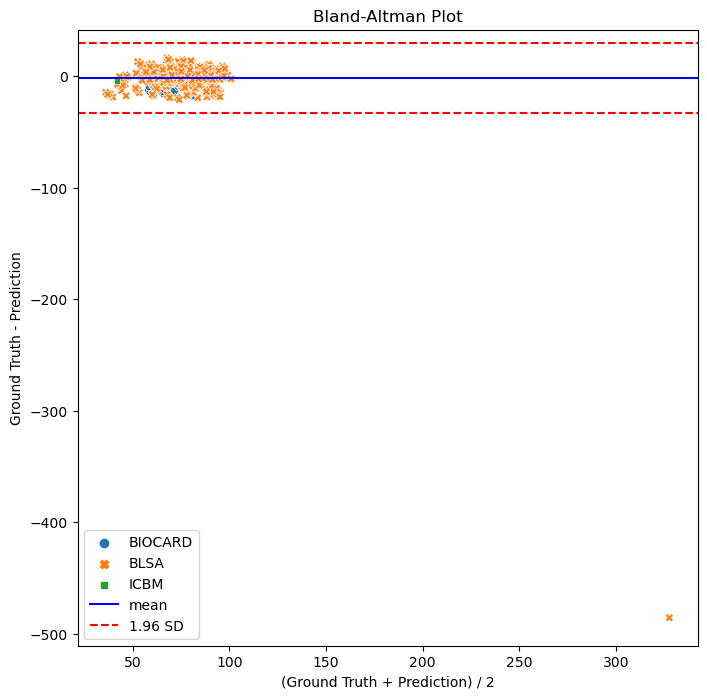

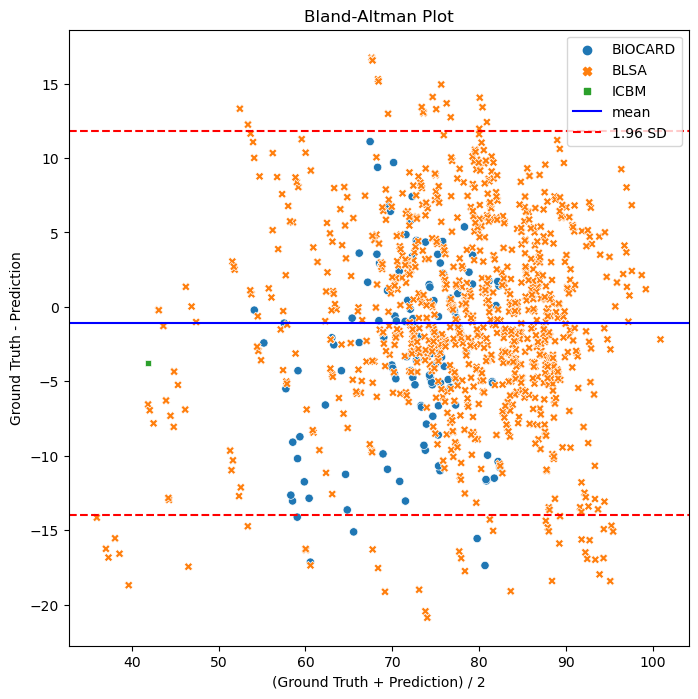

In [5]:
# Visualize results
from functions import make_BlandAltman_plot

df_discuss_healthy['diff'] = df_discuss_healthy['Age'] - df_discuss_healthy['Age_predicted']
df_discuss_healthy['average'] = (df_discuss_healthy['Age'] + df_discuss_healthy['Age_predicted']) / 2

# All predictions
make_BlandAltman_plot(df_discuss_healthy, 
                      save_to='./figs/BlandAltman_plot_test_healthy_all.png', 
                      figsize=(8, 8))

# Remove the outlier
make_BlandAltman_plot(df_discuss_healthy.drop(df_discuss_healthy.loc[df_discuss_healthy['average']>300,].index), 
                      save_to='./figs/BlandAltman_plot_test_healthy_threshold.png', 
                      figsize=(8, 8))

#### Cohort 2: Impaired subjects

In [6]:
# Load data
df_test_impaired = pd.read_csv('./data/ROIbased_measure_test_impaired.csv')
df_test_impaired.dropna(inplace=True)
df_test_impaired_encoded = pd.get_dummies(df_test_impaired, columns=['Sex'], drop_first=True)

X_test_impaired = df_test_impaired_encoded.drop(['Dataset', 'Subject', 'Session', 'Sample', 'Diagnosis', 'Age'], axis=1)
y_test_impaired = df_test_impaired_encoded['Age']  # n x 1

X_test_impaired = torch.Tensor(X_test_impaired.values)
y_test_impaired = torch.Tensor(y_test_impaired.values.reshape(-1,1))

# Test model
model.eval()
with torch.no_grad():
    outputs = model(X_test_impaired)
    
mae = torch.mean(torch.abs(outputs - y_test_impaired).float())
print("MAE (test_impaired) = {}".format(mae.item()))

# Save to csv
df_discuss_impaired = df_test_impaired_encoded[['Dataset', 'Subject', 'Session', 'Sample', 'Diagnosis', 'Age']]
df_discuss_impaired['Age_predicted'] = torch.squeeze(outputs).tolist()
df_discuss_impaired.to_csv('./MLP_prediction_test_impaired.csv')    

MAE (test_impaired) = 5.1020660400390625


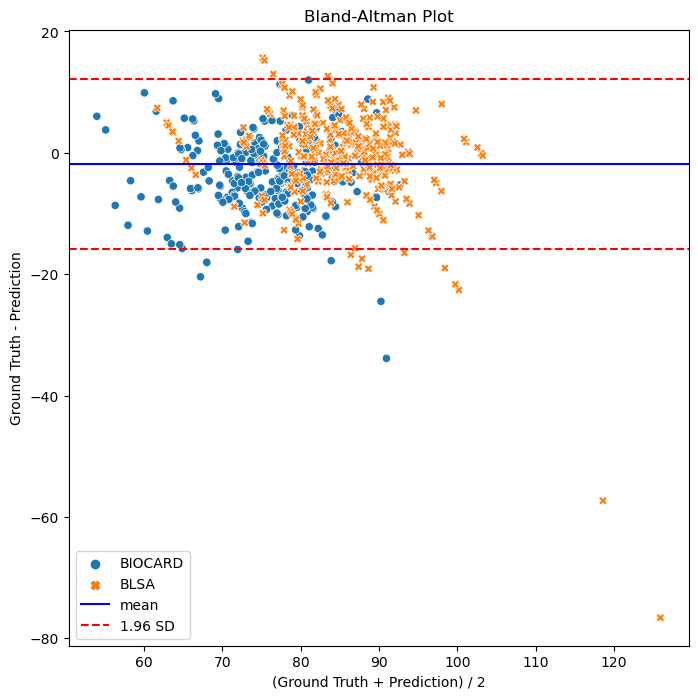

In [7]:
# Visualize results
df_discuss_impaired['diff'] = df_discuss_impaired['Age'] - df_discuss_impaired['Age_predicted']
df_discuss_impaired['average'] = (df_discuss_impaired['Age'] + df_discuss_impaired['Age_predicted']) / 2

# All predictions
make_BlandAltman_plot(df_discuss_impaired, 
                      save_to='./figs/BlandAltman_plot_test_impaired_all.png', 
                      figsize=(8, 8))

### Healthy vs Impaired

Text(0.5, 1.0, '')

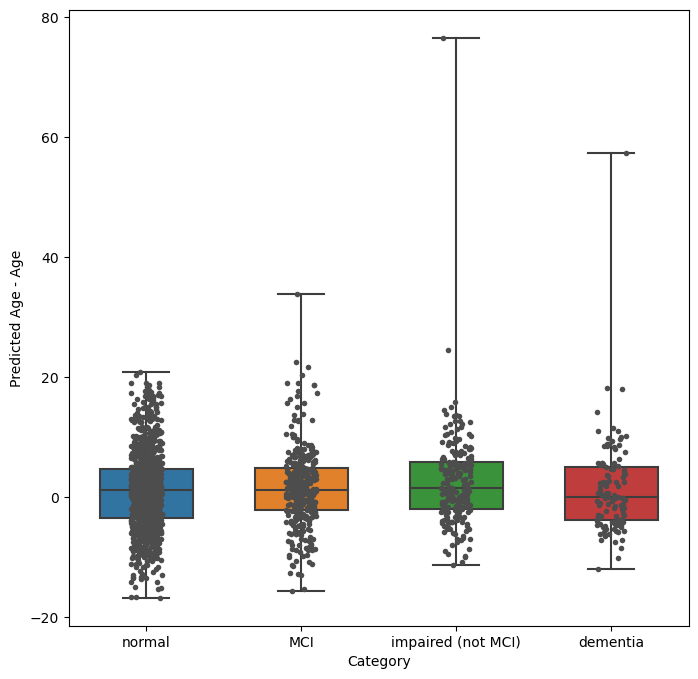

In [34]:
df_plot = pd.concat([df_discuss_healthy.drop(df_discuss_healthy.loc[df_discuss_healthy['diff'].abs()>100,].index), 
                     df_discuss_impaired.drop(df_discuss_impaired.loc[df_discuss_impaired['diff'].abs()>100,].index)
                     ])
df_plot['diff'] = -df_plot['diff']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))

sns.boxplot(x="Diagnosis", y="diff", data=df_plot,
            whis=[0, 100], width=.6, ax=ax)

sns.stripplot(x="Diagnosis", y="diff", data=df_plot,
              size=4, color=".3", linewidth=0, ax=ax)


ax.set_xlabel('Category')
ax.set_ylabel('Predicted Age - Age')
ax.set_title('')

# ax.legend()
    
# fig.savefig(save_to)